# House Prices Prediction – Advanced Regression

This notebook aims to predict house prices using the Ames Housing Dataset from the Kaggle competition: *House Prices – Advanced Regression Techniques*.

## Step 1: Load and Explore the Data

In this step, we will:
- Import required libraries
- Load the training and test datasets
- View the structure of the data
- Perform initial exploration


In [23]:
# Import standard data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for seaborn plots
sns.set(style="whitegrid")

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")


In [25]:
# Load the training and test datasets using absolute path
train_df = pd.read_csv("D:/Python Projects/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("D:/Python Projects/house-prices-advanced-regression-techniques/test.csv")

# Display the shape of the datasets
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)


Training data shape: (1460, 81)
Test data shape: (1459, 80)


In [27]:
# Display the first five rows of the training dataset
train_df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Step 2: Exploratory Data Analysis – Missing Values

We will now:
- Count missing values in the training dataset
- Visualize missing data using bar plots
- Identify which columns need imputation or removal


In [29]:
# Count total missing values per column (train set)
missing_values = train_df.isnull().sum().sort_values(ascending=False)

# Filter only columns with missing data
missing_values = missing_values[missing_values > 0]

# Display top 20 features with missing values
missing_values[:20]


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

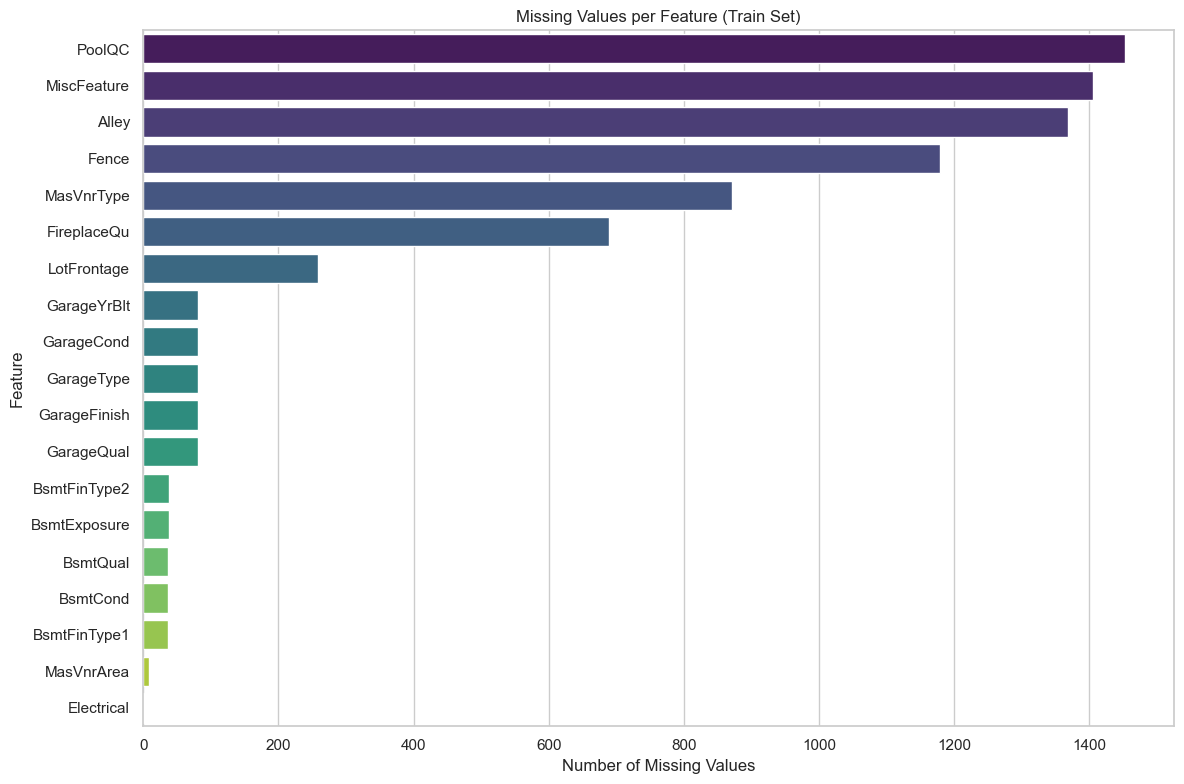

In [9]:
# Visualize top missing features using a horizontal bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=missing_values.values, y=missing_values.index, palette="viridis")
plt.title("Missing Values per Feature (Train Set)")
plt.xlabel("Number of Missing Values")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Step 2.2: Analyzing the Target Variable – SalePrice

The target variable is `SalePrice`, representing house prices in USD. We'll explore its distribution, check for skewness and kurtosis, and determine whether a log transformation is needed to normalize the values.


Skewness: 1.882876
Kurtosis: 6.536282


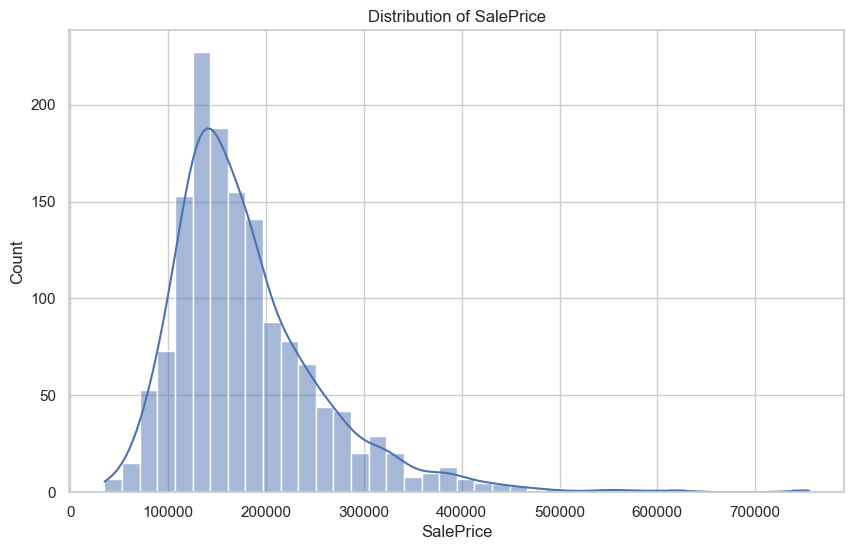

In [31]:
# Basic stats
print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())

# Distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=40)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.show()


### Skewness & Kurtosis

- A skewness > 1 suggests right skew → log transformation may help.
- Kurtosis > 3 indicates heavy tails and outliers.

We'll explore log-transformed `SalePrice` in the next step.


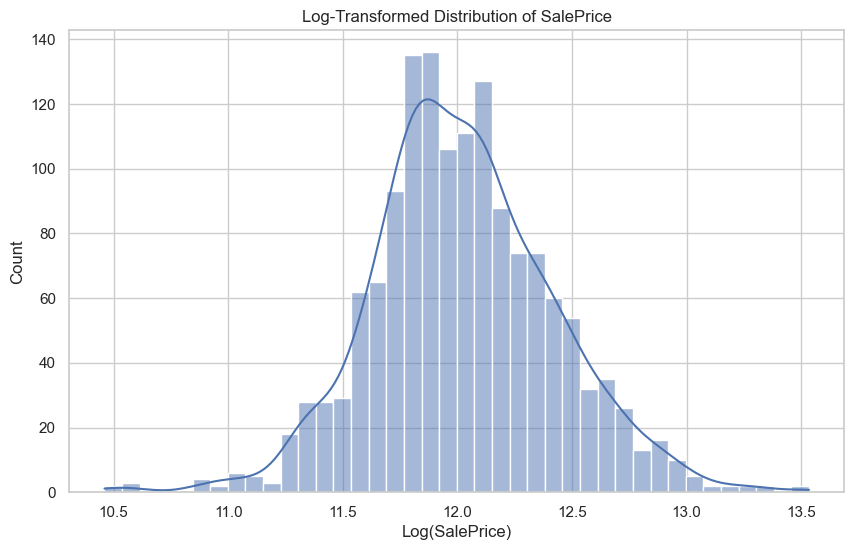

In [33]:
# Apply log1p transformation (log(1 + x))
train_df['LogSalePrice'] = np.log1p(train_df['SalePrice'])

# Visualize log-transformed SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(train_df['LogSalePrice'], kde=True, bins=40)
plt.title("Log-Transformed Distribution of SalePrice")
plt.xlabel("Log(SalePrice)")
plt.ylabel("Count")
plt.show()


## Step 2.3: Feature Correlation with SalePrice

To identify which features influence house prices the most, we'll calculate the Pearson correlation coefficients and visualize the top 10 positively correlated features.


In [35]:
# Compute correlation matrix (numeric features only)
corr_matrix = train_df.corr(numeric_only=True)

# Top 10 features most correlated with SalePrice
top_corr_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False)[1:11]
print(top_corr_features)


LogSalePrice    0.948374
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


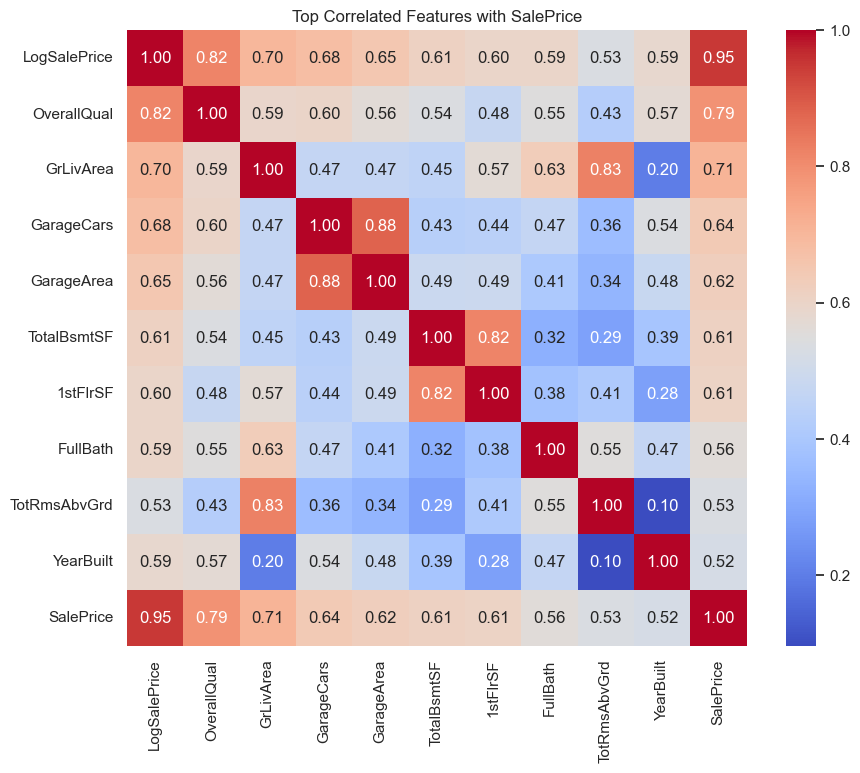

In [37]:
# Plot heatmap of top 10 correlated features
plt.figure(figsize=(10, 8))
top_corr = train_df[top_corr_features.index.tolist() + ['SalePrice']].corr()
sns.heatmap(top_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top Correlated Features with SalePrice")
plt.show()


## Step 3: Handling Missing Values Smartly

For many categorical features in this dataset, missing values indicate absence of a feature (e.g. no pool, no alley access).

We'll:
- Fill such categorical features with "None"
- Fill related numeric fields with 0
- Impute remaining missing values with mode (categorical) or median (numerical)


In [39]:
# Fill NA with 'None' where missing implies absence of feature
none_fill_cols = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'MasVnrType'
]

for col in none_fill_cols:
    train_df[col] = train_df[col].fillna('None')

# Fill corresponding numeric columns with 0 where 'no feature'
zero_fill_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF']
for col in zero_fill_cols:
    train_df[col] = train_df[col].fillna(0)

# Fill remaining numerical columns with median
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    if train_df[col].isnull().sum() > 0:
        train_df[col] = train_df[col].fillna(train_df[col].median())

# Fill remaining categorical columns with mode
categorical_cols = train_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if train_df[col].isnull().sum() > 0:
        train_df[col] = train_df[col].fillna(train_df[col].mode()[0])



In [41]:
# Confirm no missing values remain
train_df.isnull().sum().sum()


0

## Step 4: Encoding Categorical Variables

To prepare the data for machine learning models, we will convert categorical features to numerical form using one-hot encoding.


In [43]:
# Apply one-hot encoding to categorical features
train_encoded = pd.get_dummies(train_df, drop_first=True)

# Display new shape after encoding
print("Encoded train shape:", train_encoded.shape)
train_encoded.head()


Encoded train shape: (1460, 262)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,False,False,False,False,True,False,False,False,True,False
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,False,False,False,False,True,False,False,False,True,False
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,False,False,False,False,True,False,False,False,True,False
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,False,False,False,False,True,False,False,False,False,False
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,False,False,False,False,True,False,False,False,True,False


## Step 5: Model Training and Evaluation

We'll now train multiple regression models:
- Linear Regression
- Lasso Regression (L1 regularization)
- Ridge Regression (L2 regularization)

Evaluation Metric:
- Root Mean Squared Error (RMSE) using cross-validation


In [45]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np

# Drop ID and target variable from features
X = train_encoded.drop(['Id', 'SalePrice', 'LogSalePrice'], axis=1)
y = train_encoded['LogSalePrice']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [47]:
# Helper to get RMSE from cross_val_score
def rmse_cv(model):
    rmse = -cross_val_score(model, X_scaled, y, scoring="neg_root_mean_squared_error", cv=5)
    return rmse


In [49]:
# Linear Regression
lin_reg = LinearRegression()
lasso = Lasso(alpha=0.001)
ridge = Ridge(alpha=10)

models = {'Linear Regression': lin_reg, 'Lasso': lasso, 'Ridge': ridge}

for name, model in models.items():
    score = rmse_cv(model)
    print(f"{name} average RMSE: {score.mean():.4f}")


Linear Regression average RMSE: 30872021580.9741
Lasso average RMSE: 0.1612
Ridge average RMSE: 0.1582


## Step 6: Random Forest and XGBoost Regression

We will now try:
- RandomForestRegressor
- XGBRegressor

These models handle non-linear relationships and are more robust to feature interactions and scaling.


In [53]:
!pip install xgboost

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Initialize models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

models = {'Random Forest': rf, 'XGBoost': xgb}

# Evaluate using cross-validation
for name, model in models.items():
    score = rmse_cv(model)
    print(f"{name} average RMSE: {score.mean():.4f}")


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 660.6 kB/s eta 0:03:47
   ---------------------------------------- 0.1/150.0 MB 825.8 kB/s eta 0:03:02
   ---------------------------------------- 0.1/150.0 MB 819.2 kB/s eta 0:03:03
   ---------------------------------------- 0.1/150.0 MB 853.3 kB/s eta 0:02:56
   ---------------------------------------- 0.2/150.0 MB 807.1 kB/s eta 0:03:06
   ---------------------------------------- 0.2/150.0 MB 811.5 kB/s eta 0:03:05
   ---------------------------------------- 0.3/150.0 MB 827.5 kB/s eta 0:03:01
   ---------------------------------------- 0.3/150.0 MB 827.2 kB/s eta 0:03:01
   ---------------------------------------- 0.3/150.0 MB 840.2 kB/s eta 0:02:59
   ---------------------------------------- 0.4/150.0 MB 836.4 kB/s eta 0:02:59
   ---------------------------------------- 0.4/150

## Step 7: Final Model Training and Submission Preparation

Now that XGBoost is the best model, we’ll:
- Prepare the test dataset using the same preprocessing steps
- Predict `SalePrice`
- Export a submission file for Kaggle


In [55]:
# Load test.csv
test_df = pd.read_csv("D:/Python Projects/house-prices-advanced-regression-techniques/test.csv")

# Same missing value handling (reuse same logic)
for col in none_fill_cols:
    test_df[col] = test_df[col].fillna('None')

for col in zero_fill_cols:
    test_df[col] = test_df[col].fillna(0)

# Numeric + Categorical imputation
for col in test_df.select_dtypes(include=['int64', 'float64']).columns:
    if test_df[col].isnull().sum() > 0:
        test_df[col] = test_df[col].fillna(test_df[col].median())

for col in test_df.select_dtypes(include=['object']).columns:
    if test_df[col].isnull().sum() > 0:
        test_df[col] = test_df[col].fillna(test_df[col].mode()[0])


In [57]:
# One-hot encode test set
test_encoded = pd.get_dummies(test_df, drop_first=True)

# Align test set to training set columns
missing_cols = set(train_encoded.columns) - set(test_encoded.columns)
for col in missing_cols:
    test_encoded[col] = 0

test_encoded = test_encoded[train_encoded.drop(['Id', 'SalePrice', 'LogSalePrice'], axis=1).columns]


In [59]:
# Scale test features
X_test_scaled = scaler.transform(test_encoded)

# Retrain final model
final_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
final_model.fit(X_scaled, y)

# Predict (inverse log)
log_preds = final_model.predict(X_test_scaled)
final_preds = np.expm1(log_preds)


In [61]:
# Create submission dataframe
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': final_preds
})

# Save to CSV
submission.to_csv("submission.csv", index=False)
submission.head()


,Id,SalePrice
0,1461,123067.945312
1,1462,153088.343750
2,1463,184485.562500
3,1464,184972.500000
4,1465,184673.031250


In [63]:
import os
os.getcwd()


'C:\\Users\\Sparta Laptop'